In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.extmath import randomized_svd
from scipy import stats

In [30]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data

In [33]:
y = list(iris.target)

In [34]:
#wine = pd.read_csv('/Users/victor/Documents/DataLab/2018/wine.csv')

In [35]:
#wine.head()

### Standardize

In [36]:
#Y_ = wine.iloc[:,:3]
#X = wine.iloc[:,3:].as_matrix()
medias = X.mean(axis=0)
desv = X.std(axis=0)
dim = X.shape[1]

In [37]:
X_st = (X-medias)/desv

### Groups

In [76]:
#GroupNames = list(Y_.Group.unique())
GroupNames = list(y)
g = len(set(GroupNames))
n = X_st.shape[0]
m = X_st.shape[1]
r = np.min(np.array([g - 1, m]))

In [77]:
def Factor2Binary(y,Name = None):
    if Name == None:
        Name = "C"
    #ncat = len(y.unique())
    ncat = len(list(set(y)))
    n = len(y)
    #Z = pd.DataFrame(0, index=np.arange(len(y)), columns=y.unique())
    Z = pd.DataFrame(0, index=np.arange(len(y)), columns=list(set(y)))
    for col in Z.columns:
        for i in range (0,n):
            if y[i] == col:
                Z[col].iloc[i] = 1
    return Z

In [78]:
def matrixsqrt(M,dim,tol=np.finfo(float).eps,inv=True):
    U, Sigma, VT = randomized_svd(M, n_components=dim, n_iter=5, random_state=None)
    nz = Sigma > tol
    if inv==True:
        S12 = U.dot(np.diag(1/np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    else:
        S12 = U.dot(np.diag(np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    return S12

In [79]:
#Groups to Binary
Z = Factor2Binary(y)
ng = Z.sum(axis=0)
S11 = (Z.T).dot(Z)
Xb = np.linalg.inv(S11).dot(Z.T).dot(X_st)
B = (Xb.T).dot(S11).dot(Xb)
S = (X_st.T).dot(X_st) - B
Y = np.power(S11,0.5).dot(Xb).dot(matrixsqrt(S,dim,inv=True))

U, Sigma, VT = randomized_svd(Y, n_components=dim, n_iter=5, random_state=None)

#Variable_Coord
H = matrixsqrt(S,dim,inv=False).dot(np.transpose(VT[0:r,:]))
#Canonical_Weights
B = matrixsqrt(S,dim,inv=True).dot(np.transpose(VT[0:r,:]))

#Group_Coord
J = Xb.dot(B)

#Individual_Coord
V = X_st.dot(B)

In [80]:
sct = np.diag((V.T).dot(V))
sce = np.diag((J.T).dot(S11).dot(J))
scr = sct -sce
fs = (sce/(g - 1))/(scr/(n - g))

#eigenvectors
vprop = Sigma[:r]
#Inertia
iner = (np.power(vprop,2)/(np.power(vprop,2).sum()))*100

In [81]:
lamb = np.power(vprop,2)
pill = 1/(1 + lamb)
pillai = np.linalg.det(np.diag(pill))
glh = g - 1
gle = n - g
t = np.sqrt((np.power(glh,2) * np.power(m,2) - 4)/(np.power(m,2) + np.power(glh,2) - 5))
w = gle + glh - 0.5 * (m + glh + 1)
df1 = m * glh
df2 = w * t - 0.5 * (m * glh - 2)

In [82]:
Wilksf = (1 - np.power(pillai,1/t))/(np.power(pillai,1/t)) * (df2/df1)
Wilksp = stats.f.pdf(Wilksf, df1, df2)

In [84]:
Wilksf

198.71102958937774

### Radius

In [85]:
falfau = stats.t.ppf(1 - (0.025), (n - g))
falfab = stats.t.ppf(1 - (0.025/(g * m)), (n - g))
falfam = np.sqrt(stats.f.ppf(1 - 0.05, m, (n - g - m + 1)) * (((n - g) * m)/(n - g - m + 1)))
falfac = 2.447747

In [86]:
print(falfau,falfab,falfam,falfac)

1.97623330888 2.91079647977 3.15291719981 2.447747


In [87]:
UnivRad = falfau * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
BonfRad = falfab * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
MultRad = falfam * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
ChisRad = falfac * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)

In [89]:
%pylab inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [90]:
H

array([[-1.68147207, -2.37207307],
       [ 1.10980422, -8.280941  ],
       [-2.09120788, -0.49394306],
       [-2.06567372, -2.41638351]])

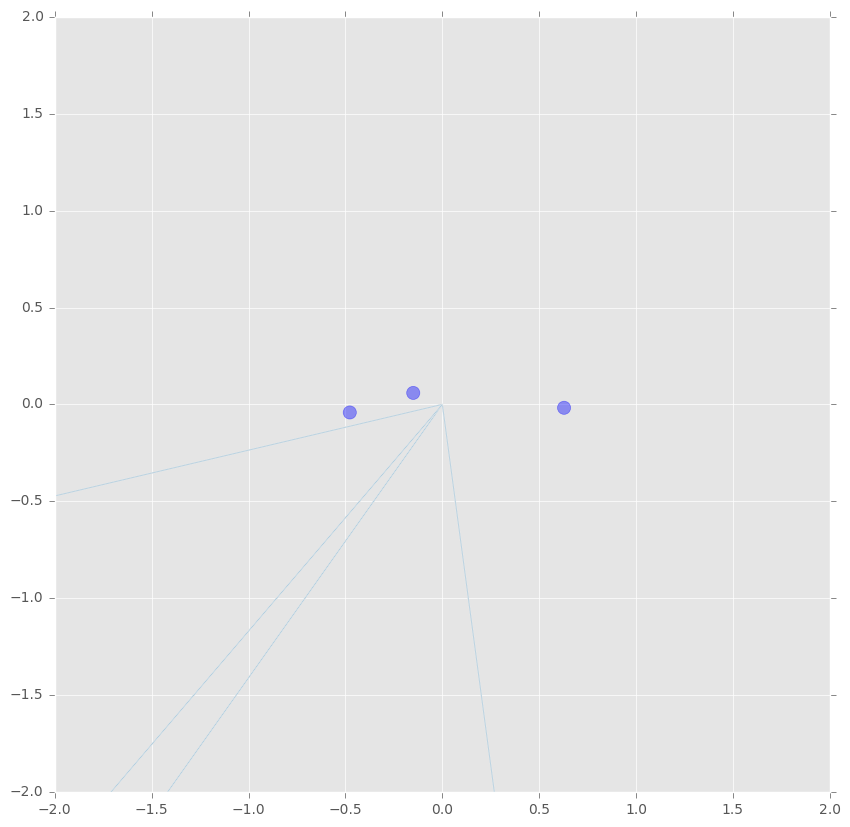

In [91]:
circle1 = plt.Circle(J[0,0:2], BonfRad[0], color='b',alpha=0.4)
circle2 = plt.Circle(J[1,0:2], BonfRad[1], color='b',alpha=0.4)
circle3 = plt.Circle(J[2,0:2], BonfRad[2], color='b',alpha=0.4)
#circle4 = plt.Circle(J[3,0:2], BonfRad[3], color='b',alpha=0.4)

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
#ax.add_artist(circle4)


#ax1.scatter(J[:,0],J[:,1])
#ax1.scatter(V[:,0],V[:,1],c='red')
for i in range(0,H.shape[0]):
    ax.arrow(0,0,H[i,0],H[i,1],width=0.005)
#ax.scatter(H[:,0],H[:,1],c='green')